<a href="https://colab.research.google.com/github/Turakulov/Python/blob/master/News_parsing%26clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import sys
# !{sys.executable} -m pip install pymorphy2

import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re

import pandas as pd
pd.set_option('display.max_rows', 500)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

from sklearn import preprocessing

import numpy as np
import nltk
nltk.download(['averaged_perceptron_tagger_ru', 'stopwords'])
stopwords = nltk.corpus.stopwords.words('russian')
#можно расширить список стоп-слов
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from tqdm import tqdm
import pymorphy2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize'] = (12, 8)
 

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 7.1MB 7.9MB/s 
[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df = pd.DataFrame(columns=['articles','category','url'], index = range(10000))

In [5]:
for x in range(990200, 990000, -1):
    h3s = BeautifulSoup(requests.get(f"https://iz.ru/{x}").text, "html.parser").find_all("div", {"id": "block-purple-content"})
    txts = ' '.join(re.findall("<p>(.*?)</p>", str(h3s)))
    txts = re.sub("<[/ai](.*?)>", "", txts)
    try:
        rub = ''.join([l.find_all("a")[0]['href'] for l in h3s])
        rub = rub.replace("/rubric/", "")
    except:
        rub = 'NaN'
    df.loc[x-990001].articles = txts
    df.loc[x-990001].category = rub
    df.loc[x-990001].url = "https://iz.ru/" + str(x)
df

,articles,category,url
0,На Украине выздоровели восемь пациентов с коро...,mir,https://iz.ru/990001
1,Российские военные оперативно выполнили поруче...,armiia,https://iz.ru/990002
2,,mir,https://iz.ru/990003
3,Работа горнолыжного курорта «Большой Вудъявр» ...,novosti-kompanii,https://iz.ru/990004
4,"Индийский столичный округ Дели, в состав котор...",mir,https://iz.ru/990005
...,...,...,...
9995,NaN,NaN,NaN
9996,NaN,NaN,NaN
9997,NaN,NaN,NaN
9998,NaN,NaN,NaN


In [0]:
df2 = df

In [0]:
df2 = df2.drop(df2[df2['articles'] == ""].index)
df2 = df2.drop(df2[df2['category'].str.contains('https', regex=False)].index)
df2 = df2.reset_index(drop=True)

In [0]:
print(df2.groupby('category')['url'].nunique())

In [15]:
df2 = df2.drop(df2[df2['category'] == "/press-release"].index)
df2 = df2.drop(df2[df2['category'] == "armiia"].index)
df2 = df2.drop(df2[df2['category'] == "auto"].index)
df2 = df2.drop(df2[df2['category'] == "internet"].index)
df2 = df2.drop(df2[df2['category'] == "kultura"].index)
df2 = df2.drop(df2[df2['category'] == "nauka"].index)
df2 = df2.drop(df2[df2['category'] == "novosti-kompanii"].index)
df2 = df2.drop(df2[df2['category'] == "obshchestvo"].index)
df2 = df2.drop(df2[df2['category'] == "politika"].index)
df2 = df2.drop(df2[df2['category'] == "proisshestviia"].index)
df2 = df2.drop(df2[df2['category'] == "stil"].index)
df2 = df2.drop(df2[df2['category'] == "strana"].index)
df2 = df2.drop(df2[df2['category'] == "turizm"].index)
df2 = df2.reset_index(drop=True)
print(df2.groupby('category')['articles'].nunique())

category
ekonomika     386
mir          1207
sport         227
Name: articles, dtype: int64


In [7]:
df2 = df2.drop(['url'], axis=1)
df2.head()

,articles,category
0,На Украине выздоровели восемь пациентов с коро...,mir
1,"Индийский столичный округ Дели, в состав котор...",mir
2,Кабинет министров Германии и правительства фед...,mir
3,Правительство Испании продлит действие режима ...,mir
4,Испанский оперный певец Пласидо Доминго заявил...,mir


In [0]:
morph = pymorphy2.MorphAnalyzer()

In [0]:
imp_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']

def getMostFrequentWordsFiltered(text):
    
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    text = ' '.join(words)
    
    counter=CountVectorizer(ngram_range=(1,2), stop_words=stopwords, token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
    res=counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:5]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

In [12]:
freqwords = []
vocabs = []
for i in tqdm(range(df2.shape[0])):
    fw, v = getMostFrequentWordsFiltered(df2.articles.iloc[i])
    freqwords.append(fw)
    vocabs.append(v)
    
df2['Vocabular'] = vocabs
df2['Freq Words'] = freqwords
df2.head(10)

100%|██████████| 1822/1822 [02:12<00:00, 13.76it/s]


,articles,category,Vocabular,Freq Words
0,На Украине выздоровели восемь пациентов с коро...,mir,"{'украина': 4, 'выздороветь': 2, 'пациент': 2,...","[коронавирус, украина, человек, тысяча, центр]"
1,"Индийский столичный округ Дели, в состав котор...",mir,"{'индийский': 1, 'столичный': 1, 'дели': 3, 'с...","[март, человек, весь, дели, год]"
2,Кабинет министров Германии и правительства фед...,mir,"{'кабинет': 1, 'министр': 1, 'германия': 1, 'п...","[человек, март, тысяча, фрг, агентство]"
3,Правительство Испании продлит действие режима ...,mir,"{'правительство': 2, 'испания': 5, 'продлить':...","[страна, испания, март, ограничение, тысяча]"
4,Испанский оперный певец Пласидо Доминго заявил...,mir,"{'испанский': 1, 'оперный': 2, 'певец': 2, 'пл...","[март, весь, вирус, коронавирус, человек]"
5,"Во Франции скончался первый врач, боровшийся с...",mir,"{'франция': 3, 'скончаться': 4, 'врач': 5, 'бо...","[врач, скончаться, тысяча, коронавирус, франция]"
6,Чемпион UFC в легком весе Хабиб Нурмагомедов п...,sport,"{'чемпион': 3, 'лёгкое': 3, 'вес': 3, 'хабиб':...","[вес, лёгкое, лёгкое вес, чемпион, чемпион лёг..."
7,Американский боец смешанного стиля UFC Тони Фе...,sport,"{'американский': 1, 'боец': 1, 'смешанный': 1,...","[американский, американский боец, боец, боец с..."
8,Российский нападающий клуба «Сент-Луис Блюз» В...,sport,"{'российский': 1, 'нападать': 2, 'клуб': 2, 'с...","[кубок, тарасенко, серия, сказать, команда]"
9,С 23 марта в Греции вводятся ограничения на ав...,mir,"{'март': 5, 'греция': 4, 'вводиться': 1, 'огра...","[март, греция, коронавирус, воскресение, мера]"


In [0]:
def normalizePymorphy2(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words

In [0]:
tfCounter = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)
tfres = tfCounter.fit_transform([' '.join(normalizePymorphy2(n)) for n in df2.articles] )

In [16]:
print(tfres.shape)

(1822, 142683)


In [17]:
freqwords = []
for i in tqdm(range(df2.shape[0])):

    tfs = [(k,tfres[i][0, tfCounter.vocabulary_.get(k)]) for k in df2.Vocabular.iloc[i] 
         if k in tfCounter.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:5]]
    freqwords.append(fw)
    
df2['Freq Words TFIDF'] = freqwords
df2.head(10)

100%|██████████| 1822/1822 [00:41<00:00, 43.55it/s]


,articles,category,Vocabular,Freq Words,Freq Words TFIDF
0,На Украине выздоровели восемь пациентов с коро...,mir,"{'украина': 4, 'выздороветь': 2, 'пациент': 2,...","[коронавирус, украина, человек, тысяча, центр]","[украина выздороветь, украина, центр, воскресе..."
1,"Индийский столичный округ Дели, в состав котор...",mir,"{'индийский': 1, 'столичный': 1, 'дели': 3, 'с...","[март, человек, весь, дели, год]","[дели, частное, работать, рекомендовать, март]"
2,Кабинет министров Германии и правительства фед...,mir,"{'кабинет': 1, 'министр': 1, 'германия': 1, 'п...","[человек, март, тысяча, фрг, агентство]","[фрг, меркель, человек, общефедеральный, земел..."
3,Правительство Испании продлит действие режима ...,mir,"{'правительство': 2, 'испания': 5, 'продлить':...","[страна, испания, март, ограничение, тысяча]","[испания, санчёс, правительство испания, санс,..."
4,Испанский оперный певец Пласидо Доминго заявил...,mir,"{'испанский': 1, 'оперный': 2, 'певец': 2, 'пл...","[март, весь, вирус, коронавирус, человек]","[оперный певец, оперный, доминго, певец, семья]"
5,"Во Франции скончался первый врач, боровшийся с...",mir,"{'франция': 3, 'скончаться': 4, 'врач': 5, 'бо...","[врач, скончаться, тысяча, коронавирус, франция]","[врач, верана, смерть врач, компьенить, франция]"
6,Чемпион UFC в легком весе Хабиб Нурмагомедов п...,sport,"{'чемпион': 3, 'лёгкое': 3, 'вес': 3, 'хабиб':...","[вес, лёгкое, лёгкое вес, чемпион, чемпион лёг...","[лёгкое вес, вес, лёгкое, чемпион, нурмагомед ..."
7,Американский боец смешанного стиля UFC Тони Фе...,sport,"{'американский': 1, 'боец': 1, 'смешанный': 1,...","[американский, американский боец, боец, боец с...","[петтис, фергюсон праздновать, победа энтони, ..."
8,Российский нападающий клуба «Сент-Луис Блюз» В...,sport,"{'российский': 1, 'нападать': 2, 'клуб': 2, 'с...","[кубок, тарасенко, серия, сказать, команда]","[тарасенко, кубок, новорождённый, серия, кубок..."
9,С 23 марта в Греции вводятся ограничения на ав...,mir,"{'март': 5, 'греция': 4, 'вводиться': 1, 'огра...","[март, греция, коронавирус, воскресение, мера]","[греция, поездка, воскресение, мицотакиснуть, ..."


In [18]:
df2 = df2.drop(['Vocabular'], axis=1)
df2 = df2.drop(['Freq Words'], axis=1)

le = preprocessing.LabelEncoder()

df2['category'] = le.fit_transform(df2['category'])

df2.head(10)

,articles,category,Freq Words TFIDF
0,На Украине выздоровели восемь пациентов с коро...,1,"[украина выздороветь, украина, центр, воскресе..."
1,"Индийский столичный округ Дели, в состав котор...",1,"[дели, частное, работать, рекомендовать, март]"
2,Кабинет министров Германии и правительства фед...,1,"[фрг, меркель, человек, общефедеральный, земел..."
3,Правительство Испании продлит действие режима ...,1,"[испания, санчёс, правительство испания, санс,..."
4,Испанский оперный певец Пласидо Доминго заявил...,1,"[оперный певец, оперный, доминго, певец, семья]"
5,"Во Франции скончался первый врач, боровшийся с...",1,"[врач, верана, смерть врач, компьенить, франция]"
6,Чемпион UFC в легком весе Хабиб Нурмагомедов п...,2,"[лёгкое вес, вес, лёгкое, чемпион, нурмагомед ..."
7,Американский боец смешанного стиля UFC Тони Фе...,2,"[петтис, фергюсон праздновать, победа энтони, ..."
8,Российский нападающий клуба «Сент-Луис Блюз» В...,2,"[тарасенко, кубок, новорождённый, серия, кубок..."
9,С 23 марта в Греции вводятся ограничения на ав...,1,"[греция, поездка, воскресение, мицотакиснуть, ..."


In [0]:
def optimal_cluster_elbow_method(matrix_data,max_clusters_check):
    Sum_of_squared_distances=[]
    K = range(1,max_clusters_check)
    for k  in K:
        km=KMeans(n_clusters=k)
        km=km.fit(matrix_data)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

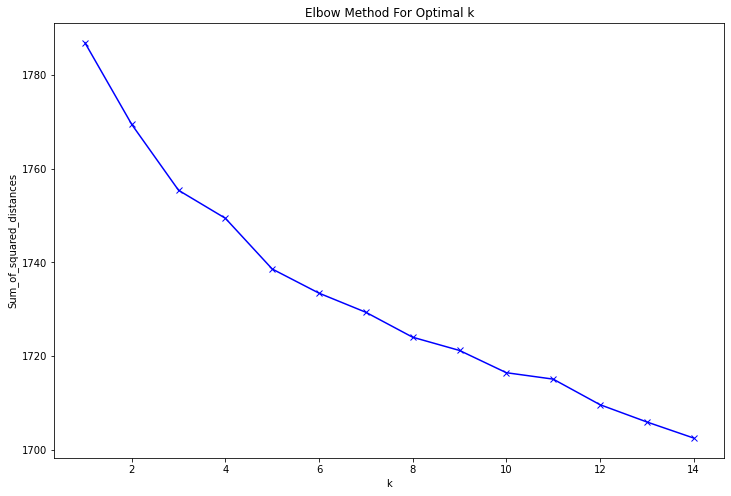

In [20]:
optimal_cluster_elbow_method(tfres,15)

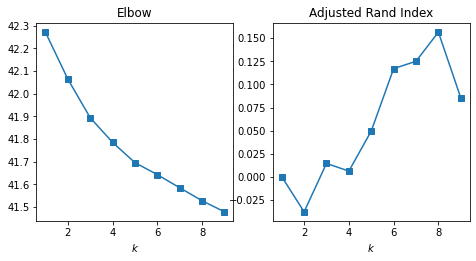

In [21]:
crit = []
ari = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(tfres)
    crit.append(np.sqrt(kmeans.inertia_))
    ari.append(adjusted_rand_score(df2['category'], kmeans.labels_))

ax1 = plt.subplot(234)
ax1.plot(range(1,10), crit, marker='s')
ax1.set_xlabel('$k$')
ax1.set_title('Elbow')

ax2 = plt.subplot(235)
ax2.plot(range(1,10), ari, marker='s')
ax2.set_xlabel('$k$')
ax2.set_title('Adjusted Rand Index')

plt.show()

In [22]:
kmeans1 = KMeans(n_clusters=3, random_state=1).fit(tfres)
kmeans1.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.38765105e-04, 2.63405896e-04, 0.00000000e+00, ...,
        4.21780433e-04, 1.05587695e-04, 1.05587695e-04],
       [2.25287427e-04, 0.00000000e+00, 6.59318734e-05, ...,
        1.23089853e-04, 1.17837343e-04, 1.17837343e-04]])

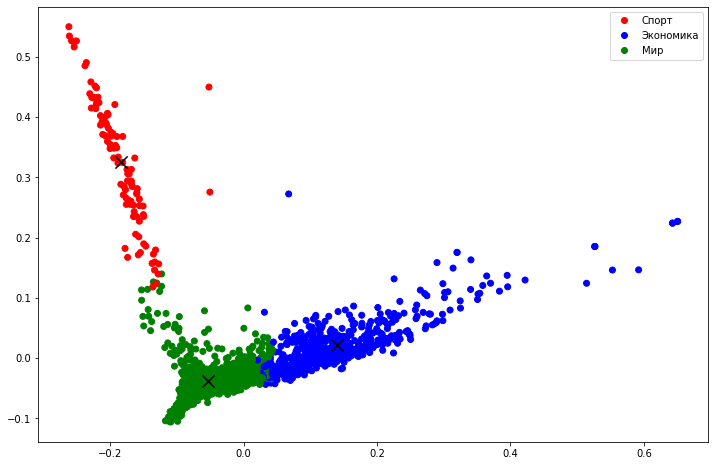

In [23]:
# Уменьшим размерность до 2D
pca = PCA(n_components=2, random_state=1)
reduced_features = pca.fit_transform(tfres.toarray())

# Уменьшим центры кластеров до 2D
reduced_cluster_centers = pca.transform(kmeans1.cluster_centers_)

classes = ['Спорт', 'Экономика', 'Мир']
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans1.predict(tfres), cmap=colours)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='black')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [0]:
import umap

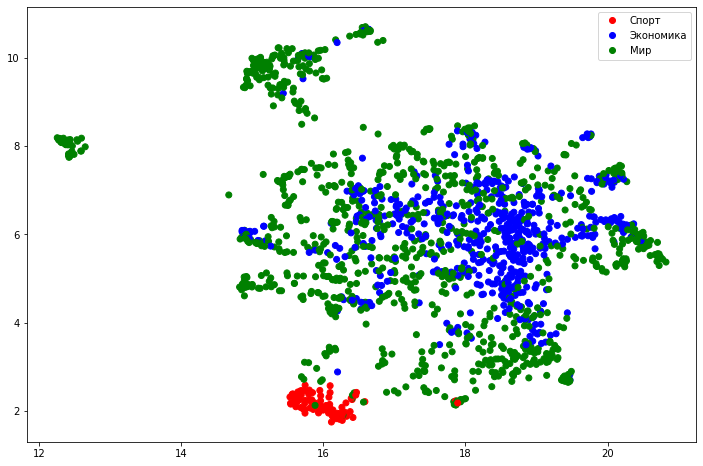

In [25]:
show_reduced = umap.UMAP(n_neighbors=30).fit_transform(tfres)

classes = ['Спорт', 'Экономика', 'Мир']
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(show_reduced[:,0], show_reduced[:,1], c=kmeans1.predict(tfres), cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)